<a href="https://colab.research.google.com/github/NckYang/Baseball-Prediction-Project/blob/main/Mixed_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive
--- 發現檔案 'statcast_data_2022_2025_full.parquet'，直接讀取 ---

開始計算球員累積強弱特徵 (這可能需要幾分鐘)...
  -> 計算打者歷史數據...
  -> 計算投手歷史數據...
球員累積特徵計算完成！

##############################
### 階段一：準備訓練與驗證集 ###
##############################
將使用 2023-04-03 之前的所有數據 (共 733801 筆) 訓練通用模型。
將在 2023-04-03 之後的數據中進行驗證...

開始訓練【v34 宏觀策略模型】...
【v34 宏觀策略模型】訓練完成！

##############################
### 階段二：開始系統性驗證 ###
##############################
  -> 正在為驗證集準備特徵...
  -> 正在從驗證集中篩選關鍵情境...

### 系統性回測最終報告 (v34 宏觀模型 - 含球員特徵) ###

--- 驗證情境: 3B1S ---
  -> 平均預測上壘機率: 0.3421 (34.21%)
  -> 該情境真實上壘機率: 0.3478 (34.78%)
  -> Brier 分數 (機率誤差): 0.2271 (越低越好)
  -> Log Loss (對數損失): 0.6468 (越低越好)
  -> 系統綜合準確率 (Accuracy at 0.5): 0.6519
  -> 系統上壘類別 F1-Score (at 0.5): 0.0093

  詳細分類報告 (at 0.5):
              precision    recall  f1-score   support

  At-Bat Out     0.6526    0.9970    0.7889     30494
     On Base     0.4578    0.0047    0.0093     16260

    accuracy                         0.6519     46754
   macro avg    

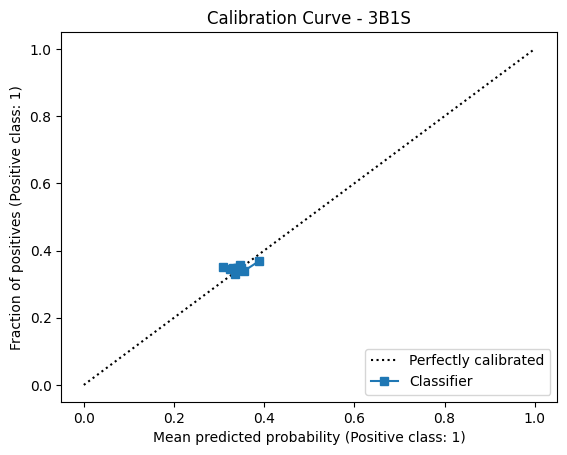


--- 驗證情境: 2S_AllB ---
  -> 平均預測上壘機率: 0.3187 (31.87%)
  -> 該情境真實上壘機率: 0.3181 (31.81%)
  -> Brier 分數 (機率誤差): 0.2171 (越低越好)
  -> Log Loss (對數損失): 0.6259 (越低越好)
  -> 系統綜合準確率 (Accuracy at 0.5): 0.6818
  -> 系統上壘類別 F1-Score (at 0.5): 0.0006

  詳細分類報告 (at 0.5):
              precision    recall  f1-score   support

  At-Bat Out     0.6819    0.9997    0.8107    450250
     On Base     0.3280    0.0003    0.0006    210084

    accuracy                         0.6818    660334
   macro avg     0.5049    0.5000    0.4057    660334
weighted avg     0.5693    0.6818    0.5530    660334



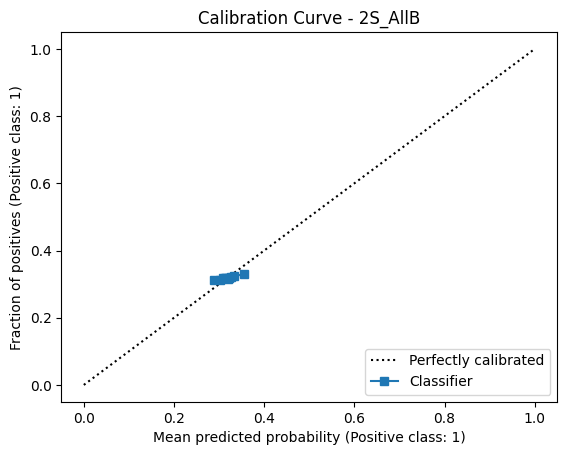

In [4]:
# -*- coding: utf-8 -*-
"""
Baseball Prediction v34.0 - Macro-Strategy Model

MLB Statcast 打者上壘預測模型 - 可分析多種對決情況
*** 版本 34.0 - 放棄物理模擬，回歸宏觀策略模型 ***
"""

# ========== 1. 安裝與匯入套件 ==========
!pip install pybaseball xgboost scikit-learn pandas numpy matplotlib seaborn imbalanced-learn fastparquet -q

import pandas as pd
import numpy as np
import os
import gc
from pybaseball import statcast, playerid_lookup
from datetime import datetime
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score, brier_score_loss
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ========== 1.5 掛接 Google 雲端硬碟 ==========
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# ========== 2. 輔助函式 ==========
ESSENTIAL_COLUMNS = [
    'game_date','batter','pitcher','events','strikes','balls','pitch_type', 'description',
    'outs_when_up','inning','home_team','p_throws','release_speed', 'release_spin_rate', 'game_pk',
    'plate_x','plate_z','pitch_number','at_bat_number',
    'on_1b','on_2b','on_3b','bat_score','fld_score',
    'stand', 'type'
]

def get_statcast_data(file_path):
    if os.path.exists(file_path):
        print(f"--- 發現檔案 '{os.path.basename(file_path)}'，直接讀取 ---")
        return pd.read_parquet(file_path)
    else:
        print(f"錯誤：找不到指定的數據檔案 '{file_path}'。")
        return None

def add_player_career_stats(df):
    """
    為數據集加入打者與投手的「賽前/打席前」累積數據特徵 (Step A)。
    包含：打擊率 (AVG), 上壘率 (OBP), 長打率 (SLG), OPS, 投手被打擊率 (Opp AVG), 三振率 (K%)
    """
    print("\n" + "="*80)
    print("開始計算球員累積強弱特徵 (這可能需要幾分鐘)...")

    # 複製一份以避免修改原始資料
    df_stats = df.copy()

    # 1. 確保數據按時間排序 (這點至關重要，否則會用到未來的數據預測過去)
    # 確保 game_date 是時間格式
    if df_stats['game_date'].dtype == 'object':
        df_stats['game_date'] = pd.to_datetime(df_stats['game_date'])

    df_stats = df_stats.sort_values(by=['game_date', 'game_pk', 'at_bat_number', 'pitch_number'])

    # 2. 定義打擊事件結果
    # 定義哪些事件算打數 (AB), 安打 (H), 上壘 (OB), 長打權重 (TB)
    # 注意：這裡做簡化計算，主要為了捕捉強弱趨勢

    # 轉成字串以免報錯
    df_stats['events'] = df_stats['events'].fillna('')

    # 標記每個打席的產出 (只看打席結束的那一球)
    # 這裡我們只取每個打席的「最後一球」來計算成績，避免重複計算
    # 但為了方便合併回逐球數據，我們先對全體計算，最後再 shift

    # 輔助欄位：是否為打席結束
    at_bat_end_events = [
        'single', 'double', 'triple', 'home_run', 'strikeout',
        'walk', 'hit_by_pitch', 'field_out', 'pop_out', 'fly_out',
        'grounded_into_double_play', 'force_out', 'sac_fly', 'sac_bunt', 'field_error'
    ]
    df_stats['is_ab_end'] = df_stats['events'].isin(at_bat_end_events).astype(int)

    # 計算基礎數據 (Base Stats)
    df_stats['is_hit'] = df_stats['events'].isin(['single', 'double', 'triple', 'home_run']).astype(int)
    df_stats['is_ab'] = df_stats['events'].isin(['single', 'double', 'triple', 'home_run', 'strikeout', 'field_out', 'pop_out', 'fly_out', 'grounded_into_double_play']).astype(int)
    df_stats['is_on_base'] = df_stats['events'].isin(['single', 'double', 'triple', 'home_run', 'walk', 'hit_by_pitch']).astype(int)
    df_stats['is_k'] = (df_stats['events'] == 'strikeout').astype(int)
    df_stats['is_bb'] = (df_stats['events'] == 'walk').astype(int)

    # 計算長打數 (Total Bases) - 簡化版
    conditions = [
        (df_stats['events'] == 'single'),
        (df_stats['events'] == 'double'),
        (df_stats['events'] == 'triple'),
        (df_stats['events'] == 'home_run')
    ]
    choices = [1, 2, 3, 4]
    df_stats['total_bases'] = np.select(conditions, choices, default=0)

    # ==========================================
    # 3. 計算打者累積數據 (Batter Stats)
    # ==========================================
    print("  -> 計算打者歷史數據...")

    # 使用 expanding().sum() 計算累加，這比迴圈快很多
    # shift(1) 是關鍵：我們只能看到「這個打席之前」的數據，不能包含現在這個打席

    batter_group = df_stats.groupby('batter')

    # 累積打數, 安打, 上壘, 總壘打數, 保送 (加上 shift(1) 避免 Data Leakage)
    # 注意：我們只在 'is_ab_end' 為 1 的時候才真正有數據產出，
    # 但為了讓每個 pitch 都有當下的累積數據，我們對所有 row 做 expanding，但只累加 is_ab_end 的行

    # 為了效能，我們先把非打席結束的行設為 0，這樣累加時就不會變
    # 但我們要預測的那一球，必須擁有「之前」累積的數據

    # 技巧：先算出每個打者的累加數據
    df_stats['b_cum_ab'] = batter_group['is_ab'].transform(lambda x: x.shift(1).fillna(0).cumsum())
    df_stats['b_cum_h'] = batter_group['is_hit'].transform(lambda x: x.shift(1).fillna(0).cumsum())
    df_stats['b_cum_ob'] = batter_group['is_on_base'].transform(lambda x: x.shift(1).fillna(0).cumsum())
    df_stats['b_cum_tb'] = batter_group['total_bases'].transform(lambda x: x.shift(1).fillna(0).cumsum())
    df_stats['b_cum_pa'] = batter_group['is_ab_end'].transform(lambda x: x.shift(1).fillna(0).cumsum()) # Plate Appearances

    # 計算率值 (處理除以 0 的情況)
    # 打擊率 AVG
    df_stats['batter_avg'] = df_stats['b_cum_h'] / df_stats['b_cum_ab'].replace(0, 1)
    # 上壘率 OBP (簡化版: 安打+保送 / 打席)
    df_stats['batter_obp'] = df_stats['b_cum_ob'] / df_stats['b_cum_pa'].replace(0, 1)
    # 長打率 SLG
    df_stats['batter_slg'] = df_stats['b_cum_tb'] / df_stats['b_cum_ab'].replace(0, 1)
    # 攻擊指數 OPS
    df_stats['batter_ops'] = df_stats['batter_obp'] + df_stats['batter_slg']

    # 修正初期波動：如果打席數 < 10，用平均值填充或設為 0
    low_sample_mask = df_stats['b_cum_pa'] < 10
    df_stats.loc[low_sample_mask, ['batter_avg', 'batter_obp', 'batter_slg', 'batter_ops']] = 0.250 # 給個聯盟平均值當基底

    # ==========================================
    # 4. 計算投手累積數據 (Pitcher Stats)
    # ==========================================
    print("  -> 計算投手歷史數據...")

    pitcher_group = df_stats.groupby('pitcher')

    # 累積 面對打席, 被安打, 三振, 保送
    df_stats['p_cum_pa'] = pitcher_group['is_ab_end'].transform(lambda x: x.shift(1).fillna(0).cumsum())
    df_stats['p_cum_h'] = pitcher_group['is_hit'].transform(lambda x: x.shift(1).fillna(0).cumsum())
    df_stats['p_cum_k'] = pitcher_group['is_k'].transform(lambda x: x.shift(1).fillna(0).cumsum())
    df_stats['p_cum_bb'] = pitcher_group['is_bb'].transform(lambda x: x.shift(1).fillna(0).cumsum())

    # 計算率值
    # 被打擊率 Opp AVG (簡化版: 被安打 / (面對打席 - 保送)) - 這裡用 PA 近似
    df_stats['pitcher_opp_avg'] = df_stats['p_cum_h'] / (df_stats['p_cum_pa'] - df_stats['p_cum_bb']).replace(0, 1)
    # 三振率 K%
    df_stats['pitcher_k_rate'] = df_stats['p_cum_k'] / df_stats['p_cum_pa'].replace(0, 1)
    # 每局被上壘率 WHIP (簡化版: (被安打+保送) / 局數) -> 這裡用 PA/4.2 近似局數
    est_innings = df_stats['p_cum_pa'] / 4.2  # 粗略估計
    df_stats['pitcher_whip'] = (df_stats['p_cum_h'] + df_stats['p_cum_bb']) / est_innings.replace(0, 1)

    # 修正初期波動
    low_sample_mask_p = df_stats['p_cum_pa'] < 10
    df_stats.loc[low_sample_mask_p, ['pitcher_opp_avg']] = 0.240
    df_stats.loc[low_sample_mask_p, ['pitcher_k_rate']] = 0.200
    df_stats.loc[low_sample_mask_p, ['pitcher_whip']] = 1.30

    # ==========================================
    # 5. 清理與回傳
    # ==========================================
    # 選擇要保留的新特徵
    new_features = [
        'batter_avg', 'batter_ops', 'batter_slg',
        'pitcher_opp_avg', 'pitcher_k_rate', 'pitcher_whip'
    ]

    # 填補缺失值 (以防萬一)
    df_stats[new_features] = df_stats[new_features].fillna(0)

    print("球員累積特徵計算完成！")
    return df_stats

def simplify_pitch_type(pitch):
    if pitch in ['FF', 'SI', 'FC', 'FT']: return 'FB_Fastball'
    elif pitch in ['SL', 'CU', 'ST', 'KC']: return 'BB_Breaking'
    elif pitch in ['CH', 'FS', 'FO']: return 'OS_Offspeed'
    return 'Other'




# ========== 3. v34 核心訓練與驗證模組 ==========

def train_at_bat_outcome_model_v34(df_train):
    """【v34 核心模型】訓練「打席最終結果」宏觀策略模型。"""
    print("\n" + "="*80); print(f"開始訓練【v34 宏觀策略模型】...")
    model_data = df_train.copy()

    # 1. 建立預測目標：at_bat_outcome
    at_bat_ending_events = ['single', 'double', 'triple', 'home_run', 'walk', 'hit_by_pitch', 'field_out', 'strikeout', 'grounded_into_double_play', 'force_out', 'sac_fly', 'sac_bunt', 'fielders_choice_out', 'field_error', 'double_play']
    model_data['is_at_bat_end'] = model_data['events'].isin(at_bat_ending_events)
    model_data['final_event'] = model_data.loc[model_data['is_at_bat_end']].groupby(['game_date', 'at_bat_number'])['events'].transform('last')
    model_data['final_event'] = model_data.groupby(['game_date', 'at_bat_number'])['final_event'].fillna(method='ffill').fillna(method='bfill')
    on_base_events = ['single', 'double', 'triple', 'home_run', 'walk', 'hit_by_pitch', 'field_error']
    model_data['at_bat_outcome'] = model_data['final_event'].isin(on_base_events).astype(int)

    # 2. 建立情境特徵 和 序列特徵
    CONTEXT_FEATURES = ['balls', 'strikes', 'outs_when_up', 'inning', 'on_1b', 'on_2b', 'on_3b', 'pitch_number', 'stand', 'p_throws']
    for col in ['balls', 'strikes', 'outs_when_up', 'inning']:
        model_data[col] = model_data[col].fillna(0).astype(int)
    for col in ['on_1b', 'on_2b', 'on_3b']:
        model_data[col] = model_data[col].fillna(0).astype(int)
    for col in ['stand', 'p_throws']:
        model_data[col] = model_data[col].fillna('Unknown')
    model_data = model_data.sort_values(by=['game_pk', 'at_bat_number', 'pitch_number'])
    model_data['prev_pitch_type'] = model_data.groupby(['game_pk', 'at_bat_number'])['pitch_type'].shift(1).fillna('First_Pitch')
    key_outcomes = ['swinging_strike', 'foul', 'ball', 'called_strike', 'hit_into_play']
    model_data['pitch_outcome'] = model_data['description'].fillna('other').apply(lambda x: x if x in key_outcomes else 'other')
    model_data['prev_pitch_outcome'] = model_data.groupby(['game_pk', 'at_bat_number'])['pitch_outcome'].shift(1).fillna('First_Pitch')

    # 4. 最終數據準備
    CAT_FEATURES = ['stand', 'p_throws', 'prev_pitch_type', 'prev_pitch_outcome']
    NUM_FEATURES = [
        'balls', 'strikes', 'outs_when_up', 'inning', 'on_1b', 'on_2b', 'on_3b', 'pitch_number',
        'batter_avg', 'batter_ops', 'batter_slg',
        'pitcher_opp_avg', 'pitcher_k_rate', 'pitcher_whip'
    ]
    model_data.dropna(subset=['at_bat_outcome'], inplace=True) # <-- 新的：只檢查 at_bat_outcome

    encoders = {}
    for col in CAT_FEATURES:
        le = LabelEncoder(); model_data[col] = le.fit_transform(model_data[col].astype(str)); encoders[col] = le

    ALL_FEATURES = NUM_FEATURES + CAT_FEATURES # <-- 新的：只使用原始特徵
    X = model_data[ALL_FEATURES]; y = model_data['at_bat_outcome']

    # 檢查數據是否足夠
    if len(X) < 100:
        print("警告: v34 宏觀模型數據量不足"); return None, None, None

    # 5. 訓練 v34 核心模型
    model_scale_pos_weight = (y == 0).sum() / (y.sum() if y.sum() > 0 else 1)
    model = xgb.XGBClassifier(random_state=42, eval_metric='logloss', objective='binary:logistic', use_label_encoder=False, n_estimators=150, max_depth=5, learning_rate=0.05)
    model.fit(X, y)
    print("【v34 宏觀策略模型】訓練完成！"); return model, encoders, ALL_FEATURES

# ========== 4. v34 核心應用函式 ==========

def run_systematic_validation_v34(full_data, num_validation_samples=1000):
    """【v34 核心】執行系統性回測，並產出總體準確率報告。"""

    print("\n" + "#"*30); print("### 階段一：準備訓練與驗證集 ###"); print("#"*30)

    # 1. 篩選出所有相關對決 (3B1S 和 2S)
    is_3B1S = (full_data['balls'] == 3) & (full_data['strikes'] == 1)
    is_2S_AllB = (full_data['strikes'] == 2)

    # 轉字串確保類別型特徵一致
    full_data['events'] = full_data['events'].astype(str)
    full_data['description'] = full_data['description'].astype(str)

    target_pitches = full_data[is_3B1S | is_2S_AllB].copy()

    if len(target_pitches) < 100:
        print(f"錯誤：數據庫中只找到 {len(target_pitches)} 筆案例，數據不足以進行有意義的系統性回測。"); return

    # 2. 找到 25% 的時間分割點 (Time Series Split)
    full_data['game_date'] = pd.to_datetime(full_data['game_date'])
    split_date = full_data['game_date'].quantile(0.25, interpolation='lower')

    df_train = full_data[full_data['game_date'] < split_date].copy()
    df_validation = full_data[full_data['game_date'] >= split_date].copy()

    print(f"將使用 {split_date.date()} 之前的所有數據 (共 {len(df_train)} 筆) 訓練通用模型。")
    print(f"將在 {split_date.date()} 之後的數據中進行驗證...")

    # 3. 訓練模型
    # 注意：這裡我們移除了 partner_model 相關參數，只傳入 df_train
    # outcome_features 會自動包含您在 Step 2 加入的 'batter_avg', 'pitcher_era' 等新特徵
    outcome_model, outcome_encoders, outcome_features = train_at_bat_outcome_model_v34(df_train)

    if outcome_model is None:
        print("\n錯誤：模型訓練失敗，無法繼續驗證。"); return

    print("\n" + "#"*30); print("### 階段二：開始系統性驗證 ###"); print("#"*30)

    # 4. 準備驗證集 (df_validation)
    print("  -> 正在為驗證集準備特徵...")
    validation_data = df_validation.copy()

    # 4a. 建立預測目標 (真實答案)
    at_bat_ending_events = ['single', 'double', 'triple', 'home_run', 'walk', 'hit_by_pitch', 'field_out', 'strikeout', 'grounded_into_double_play', 'force_out', 'sac_fly', 'sac_bunt', 'fielders_choice_out', 'field_error', 'double_play']
    validation_data['is_at_bat_end'] = validation_data['events'].isin(at_bat_ending_events)
    validation_data['final_event'] = validation_data.loc[validation_data['is_at_bat_end']].groupby(['game_date', 'at_bat_number'])['events'].transform('last')
    validation_data['final_event'] = validation_data.groupby(['game_date', 'at_bat_number'])['final_event'].fillna(method='ffill').fillna(method='bfill')
    on_base_events = ['single', 'double', 'triple', 'home_run', 'walk', 'hit_by_pitch', 'field_error']
    validation_data['at_bat_outcome'] = validation_data['final_event'].isin(on_base_events).astype(int)

    # 4b. 建立基本情境特徵 (補缺失值)
    for col in ['balls', 'strikes', 'outs_when_up', 'inning']:
        validation_data[col] = validation_data[col].fillna(0).astype(int)
    for col in ['on_1b', 'on_2b', 'on_3b']:
        validation_data[col] = validation_data[col].fillna(0).astype(int)

    validation_data = validation_data.sort_values(by=['game_pk', 'at_bat_number', 'pitch_number'])
    validation_data['prev_pitch_type'] = validation_data.groupby(['game_pk', 'at_bat_number'])['pitch_type'].shift(1).fillna('First_Pitch')

    key_outcomes = ['swinging_strike', 'foul', 'ball', 'called_strike', 'hit_into_play']
    validation_data['pitch_outcome'] = validation_data['description'].fillna('other').apply(lambda x: x if x in key_outcomes else 'other')
    validation_data['prev_pitch_outcome'] = validation_data.groupby(['game_pk', 'at_bat_number'])['pitch_outcome'].shift(1).fillna('First_Pitch')

    # 4c. 處理類別特徵 (使用訓練好的 encoders)
    CAT_FEATURES = ['stand', 'p_throws', 'prev_pitch_type', 'prev_pitch_outcome']

    for col in CAT_FEATURES:
        validation_data[col] = validation_data[col].fillna('Unknown')
        le = outcome_encoders[col]
        # 處理未見過的類別：轉為 'Unknown' 或 encoders 中的第一個類別
        validation_data[col] = validation_data[col].map(lambda s: s if s in le.classes_ else 'Unknown')

        le_classes = le.classes_.tolist()
        if 'Unknown' not in le_classes:
            validation_data[col] = validation_data[col].replace('Unknown', le_classes[0])

        validation_data[col] = le.transform(validation_data[col])

    # 4d. 準備最終的 X_test 和 y_test
    validation_data.dropna(subset=['at_bat_outcome'], inplace=True)

    # 【關鍵步驟】使用訓練時確定的特徵列表 (outcome_features) 來產生 X_test
    # 這會自動抓取 Step 1 算好的 batter_avg, pitcher_era 等欄位
    # fill_value=0 會將可能的缺失值補 0 (例如新球員沒有歷史數據)
    X_test = validation_data.reindex(columns=outcome_features, fill_value=0)
    y_test = validation_data['at_bat_outcome']

    # 5. 篩選出您關心的情境並評估
    print("  -> 正在從驗證集中篩選關鍵情境...")
    is_3B1S_val = (X_test['balls'] == 3) & (X_test['strikes'] == 1)
    is_2S_AllB_val = (X_test['strikes'] == 2)

    print("\n" + "="*80); print("### 系統性回測最終報告 (v34 宏觀模型 - 含球員特徵) ###"); print("="*80)

    for context_name, context_filter in [('3B1S', is_3B1S_val), ('2S_AllB', is_2S_AllB_val)]:
        print(f"\n--- 驗證情境: {context_name} ---")
        X_context = X_test[context_filter]
        y_context = y_test[context_filter]

        if len(y_context) == 0:
            print("無足夠數據可供評估。"); continue

        y_pred_proba = outcome_model.predict_proba(X_context)[:, 1]
        y_pred_class = (y_pred_proba >= 0.5).astype(int)

        loss = log_loss(y_context, y_pred_proba)
        avg_predicted_proba = np.mean(y_pred_proba)
        avg_actual_outcome = np.mean(y_context)
        brier = brier_score_loss(y_context, y_pred_proba)

        print(f"  -> 平均預測上壘機率: {avg_predicted_proba:.4f} ({avg_predicted_proba*100:.2f}%)")
        print(f"  -> 該情境真實上壘機率: {avg_actual_outcome:.4f} ({avg_actual_outcome*100:.2f}%)")
        print(f"  -> Brier 分數 (機率誤差): {brier:.4f} (越低越好)")
        print(f"  -> Log Loss (對數損失): {loss:.4f} (越低越好)")

        accuracy = accuracy_score(y_context, y_pred_class)
        f1 = f1_score(y_context, y_pred_class, pos_label=1, zero_division=0)

        print(f"  -> 系統綜合準確率 (Accuracy at 0.5): {accuracy:.4f}")
        print(f"  -> 系統上壘類別 F1-Score (at 0.5): {f1:.4f}")
        print("\n  詳細分類報告 (at 0.5):")
        print(classification_report(y_context, y_pred_class, target_names=['At-Bat Out', 'On Base'], zero_division=0, digits=4))

        # 繪圖
        fig, ax = plt.subplots()
        CalibrationDisplay.from_predictions(y_context, y_pred_proba, n_bins=10, ax=ax, strategy='quantile')
        ax.set_title(f"Calibration Curve - {context_name}")
        plt.show()

# ========== MAIN EXECUTION BLOCK ==========
if __name__ == "__main__":
    drive_folder_path = '/content/drive/MyDrive/MLB_Statcast_Data/'
    full_data_path = os.path.join(drive_folder_path, "statcast_data_2022_2025_full.parquet")
    full_data = get_statcast_data(full_data_path)

    if full_data is not None:
        # === 修正：加入這行來計算特徵 ===
        # 這會產生 batter_avg, pitcher_whip 等欄位
        full_data = add_player_career_stats(full_data)
        # ==============================

        # 確保計算成功後，再執行驗證
        run_systematic_validation_v34(full_data=full_data)